# Customer Clustering Implementation
 - Used number of cluster N = 7
 - Used Kprototypes (combined KMeans and KModes) algorithm
 - Used Decision Tree for results interpretation
 - Simple visualization for interpretation and presentation

In [1]:
import pandas as pd
pd.set_option('max_columns', 60)

import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.preprocessing import scale
from sklearn.utils.validation import check_array
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import  GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import seaborn as sns; sns.set(style='whitegrid')
from kmodes import kprototypes

/home/yxu/.conda/envs/cloneAnaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yxu/.conda/envs/cloneAnaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/yxu/.conda/envs/cloneAnaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (ke

** init **

In [2]:
PROD = 'mjk' # 'all'
N_clusters = 7

In [3]:
input_dir = './input/'
output_dir = './output/'

In [4]:
!mkdir output/trees

mkdir: cannot create directory `output/trees': File exists


## Read and Prepare the DataFrame for Clustering
 - the scaled data frame is for performing the algorithm
 - the non-scales data frame is for interpretation

** Read the table **

In [5]:
# Specify the features to use here
NUMERICAL_FEATURES = ['age_tier', 'max_bal_3mth', 'all_acct_vint_l_bank_ph', 'TOT_SAVING_bank_ph']
CATEGORICAL_FEATURES = ['gender_id',  'cusedu_id', 'marital_id', 'intuser_fg', 'cc_type_cnt_tableflag', 'EAST'] 

In [6]:
path = os.path.join(input_dir,'allinforce_w_feature_%s.csv' % PROD)
data = pd.read_csv(path, usecols=NUMERICAL_FEATURES+CATEGORICAL_FEATURES, sep='|')
data.shape

(12123, 10)

In [7]:
# prepare the corresponding index for use
NUMERICAL_INDEX = [data.columns.values.tolist().index(feature) for feature in NUMERICAL_FEATURES]
CATEGORICAL_INDEX = [data.columns.values.tolist().index(feature) for feature in CATEGORICAL_FEATURES]

** Missing values **

In [8]:
data.isnull().mean()

max_bal_3mth               0.000577
cusedu_id                  0.035470
gender_id                  0.000000
marital_id                 0.000000
age_tier                   0.000000
intuser_fg                 0.000000
cc_type_cnt_tableflag      0.000000
TOT_SAVING_bank_ph         0.002557
all_acct_vint_l_bank_ph    0.002805
EAST                       0.109956
dtype: float64

 - Imputation

In [9]:
dict_imput = [
    {'feature':'age_tier', 'impute_with':'MEDIAN'}
]

for feature in [feat for feat in NUMERICAL_FEATURES if feat != 'age_tier']: 
    imput = {'feature': feature, 'impute_with': 'ZERO'}
    dict_imput.append(imput)

for feature in CATEGORICAL_FEATURES: 
    imput = {'feature': feature, 'impute_with': 'MODE'}
    dict_imput.append(imput)

In [10]:
for feature in dict_imput:
    if feature['impute_with'] == 'ZERO':
        v = 0
    elif feature['impute_with'] == 'CREATE_CATEGORY':
        v = 'NULL_CATEGORY'       
    elif feature['impute_with'] == 'MEDIAN':
        v = data[feature['feature']].median()
    elif feature['impute_with'] == 'MODE':
        v = data[feature['feature']].value_counts(dropna=True).index[0]

    data[feature['feature']] = data[feature['feature']].fillna(v)
    print 'Imputed missing values in feature %s with value %s' % (feature['feature'], unicode(str(v), 'utf8'))

Imputed missing values in feature age_tier with value 4.0
Imputed missing values in feature max_bal_3mth with value 0
Imputed missing values in feature all_acct_vint_l_bank_ph with value 0
Imputed missing values in feature TOT_SAVING_bank_ph with value 0
Imputed missing values in feature gender_id with value M
Imputed missing values in feature cusedu_id with value D
Imputed missing values in feature marital_id with value A
Imputed missing values in feature intuser_fg with value N
Imputed missing values in feature cc_type_cnt_tableflag with value 0
Imputed missing values in feature EAST with value 0.0


** Numerical data scale **

In [11]:
data_scaled = data.copy()
data_scaled[NUMERICAL_FEATURES] = scale(data_scaled[NUMERICAL_FEATURES])
data_scaled.shape

(12123, 10)

## Kprototypes Clustering
 - use init = 'Cao' for quick implementation
 - can also use init = 'Huang' but usually takes more time

** implement **

In [12]:
kproto = kprototypes.KPrototypes(n_clusters=N_clusters, init='Cao', verbose=2, gamma=1.5) # init='Huang' 

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [13]:
%%time
kproto.fit_predict(data_scaled.values, categorical=CATEGORICAL_INDEX)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4547, ncost: 45158.3222074
Run: 1, iteration: 2/100, moves: 2425, ncost: 40510.9754414
Run: 1, iteration: 3/100, moves: 1440, ncost: 39031.044941
Run: 1, iteration: 4/100, moves: 1126, ncost: 35204.1946163
Run: 1, iteration: 5/100, moves: 430, ncost: 34482.5649859
Run: 1, iteration: 6/100, moves: 175, ncost: 34446.5153972
Run: 1, iteration: 7/100, moves: 18, ncost: 34443.4136435
Run: 1, iteration: 8/100, moves: 6, ncost: 34442.3823061
Run: 1, iteration: 9/100, moves: 3, ncost: 34442.1588201
Run: 1, iteration: 10/100, moves: 0, ncost: 34442.1588201
CPU times: user 5min 31s, sys: 22 ms, total: 5min 31s
Wall time: 5min 30s


array([2, 4, 1, ..., 6, 1, 4], dtype=uint8)

 ** clustering results **

In [14]:
print 'k-modes (Cao) centroids:'
print kproto.cluster_centroids_
# Print training statistics
print 'Final training cost: %.5f'%kproto.cost_
print 'Training iterations: %d'%kproto.n_iter_

k-modes (Cao) centroids:
[array([[ -1.78511544e-01,  -2.47849137e-01,  -3.76077495e-01,
          5.56312938e+00],
       [  7.93945981e-02,   2.08097163e-01,   1.93616370e+00,
         -1.70251791e-01],
       [  2.24958456e-03,   1.05731089e+00,  -4.09668973e-01,
         -1.39016653e-01],
       [  1.07623939e+01,   7.88223828e-01,   3.45549142e-01,
         -2.93376484e-01],
       [ -1.55203341e-01,  -9.74984848e-01,  -2.42049006e-01,
         -7.98805558e-02],
       [  5.71782139e-02,   6.92977218e-01,  -4.08846374e-01,
         -1.44969066e-01],
       [ -7.21480111e-02,  -1.35908072e-01,  -4.11935044e-01,
         -1.29438027e-01]]), array([['M', 'D', 'B', 'N', '0', '0.0'],
       ['M', 'D', 'A', 'N', '0', '0.0'],
       ['M', 'D', 'A', 'N', '0', '0.0'],
       ['M', 'D', 'A', 'N', '0', '0.0'],
       ['M', 'D', 'B', 'N', '0', '0.0'],
       ['M', 'D', 'A', 'N', '0', '1.0'],
       ['F', 'D', 'A', 'N', '0', '0.0']],
      dtype='|S32')]
Final training cost: 34442.15882
Trainin

In [15]:
data['cluster_label'] = kproto.labels_
data['cluster_label'].value_counts() / len(data)

4    0.321043
2    0.237565
6    0.182463
1    0.150045
5    0.082488
0    0.021777
3    0.004619
Name: cluster_label, dtype: float64

** Save the data matrix with the cluster lables **

In [16]:
data.to_csv(os.path.join(output_dir,'cluster_data_w_label.csv'), index = False, sep = '|')

## Perform Decision Tree for Cluster Results Interpretation

** Dummify the X and prepare y **

In [17]:
clusterX = pd.get_dummies(data[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], columns = CATEGORICAL_FEATURES)
clusterY = data[['cluster_label']]

** Run a loop for building decision tree for each cluster, and save the trees dots files **

In [18]:
def run_DecisitonTree(_clusterX, _clusterY, _CLUSTER):
    
    print '%s start' % _CLUSTER
    y = _clusterY.apply(lambda x: 1.0 if x.values == _CLUSTER else 0.0, axis=1)
    print 'target proportion:'
    print y.value_counts()
    
    param = {'max_leaf_nodes': [10,15,20,25,30]}
    _x_cols = _clusterX.columns.values

    dt = DecisionTreeClassifier(random_state = 1, class_weight='balanced')
    clf = GridSearchCV(dt, param, cv = 5, scoring = 'roc_auc')
    clf.fit(_clusterX, y)
    
    print '\tbest score: ', clf.best_score_
    print '\tbest params: ', clf.best_params_
    
    feature_importance = clf.best_estimator_.feature_importances_
    cv_scores = cross_val_score(clf.best_estimator_, _clusterX, y, scoring = 'roc_auc', cv = 5)
    print '\tcv scores:', cv_scores
    print '\t', cv_scores.mean()
    print 'most important feature: \n \t %s gini %.3f' % (_x_cols[feature_importance.argmax()], feature_importance.max())
    
    with open(os.path.join(output_dir,'trees/cluster_%s_tree.dot' % _CLUSTER), 'w') as f:
        sk.tree.export_graphviz(clf.best_estimator_, out_file=f,
                           feature_names = _x_cols,
                           class_names = ['0','1'],
                           filled = True, rounded = True)
    
    print '%s finish --------------------------\n' % _CLUSTER

    return None

In [19]:
for i in range(N_clusters):
    run_DecisitonTree(clusterX, clusterY, i)

0 start
target proportion:
0.0    11859
1.0      264
dtype: int64
	best score:  0.993748406234
	best params:  {'max_leaf_nodes': 10}
	cv scores: [ 0.99056604  0.99056604  1.          0.98803653  0.99957824]
	0.993749367855
most important feature: 
 	 all_acct_vint_l_bank_ph gini 0.997
0 finish --------------------------

1 start
target proportion:
0.0    10304
1.0     1819
dtype: int64
	best score:  0.999304344678
	best params:  {'max_leaf_nodes': 10}
	cv scores: [ 0.9997574   1.          1.          0.99814117  0.99862259]
	0.999304232224
most important feature: 
 	 TOT_SAVING_bank_ph gini 0.948
1 finish --------------------------

2 start
target proportion:
0.0    9243
1.0    2880
dtype: int64
	best score:  0.999228749233
	best params:  {'max_leaf_nodes': 15}
	cv scores: [ 0.99950236  0.99902397  0.99999577  0.99946733  0.99815397]
	0.999228680268
most important feature: 
 	 age_tier gini 0.662
2 finish --------------------------

3 start
target proportion:
0.0    12067
1.0       56


## Simple Visualization

** Single attribute viz by clusters **

In [20]:
def viz_numeric(col, cluster_label = 'cluster_label'):
    plt.figure(figsize=(10,6))
    plt.title('%s distribution by cluster init by %s'%(col, cluster_label))
    for i in range(N_clusters):
        UPPER = np.percentile(data[col], 99.9)
        sns.distplot(data[data[cluster_label]==i][col].apply(lambda x: x if x <= UPPER else np.nan).dropna(), kde_kws={
                'label':i}, bins=30)
    sns.distplot(data[col].apply(lambda x: x if x <= UPPER else np.nan).dropna(), kde_kws={
                'label':'all'}, bins=30)
    plt.show()
    
def viz_numbers(col, cluster_label = 'cluster_label', c='c'):
    plt.figure(figsize=(8,6))
    plt.title('%s distribution by cluster init by %s'%(col, cluster_label))
    sns.regplot(x=cluster_label, y=col, data=data, fit_reg=False,
                    x_jitter = .1, y_jitter = .1, marker='+', color = c, scatter_kws = {'alpha': .2} )
    plt.xlabel('cluster')
    plt.show()
    
def viz_categorical(col, cluster_label = 'cluster_label'):
    plt.figure(figsize=(8,6))
    plt.title('%s distribution by cluster init by %s'%(col, cluster_label))
    sns.countplot(x=cluster_label, hue = col, data=data, palette = 'Set3', order=range(N_clusters), saturation= .95)
    plt.xlabel('cluster')
    plt.show()

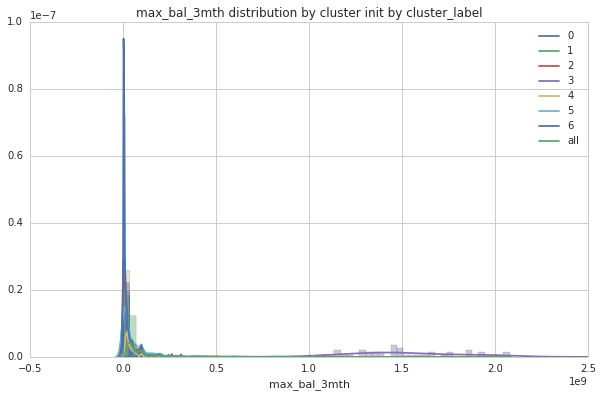

In [21]:
for col in ['max_bal_3mth']:
    viz_numeric(col, 'cluster_label')

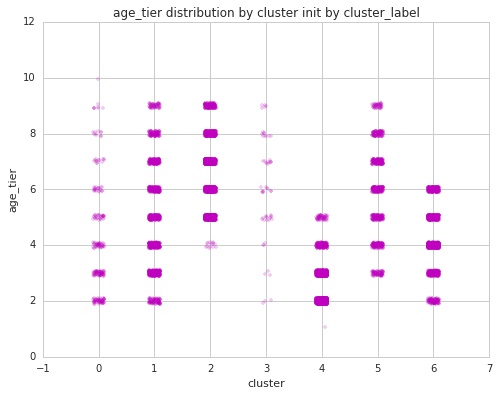

In [22]:
viz_numbers('age_tier', 'cluster_label', 'm')

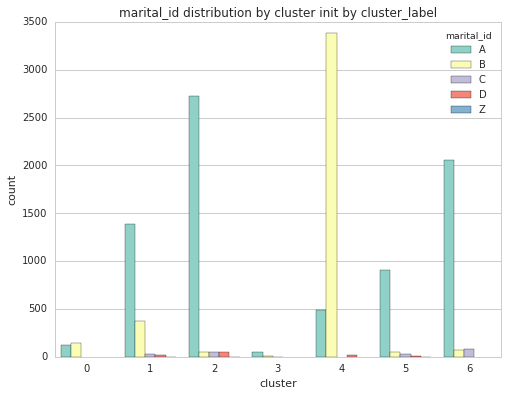

In [23]:
viz_categorical('marital_id', 'cluster_label')

** Joint plots: viz interaction of 2 attributes by clusters **

In [24]:
cluster_color = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'purple', 7: 'orange'}

In [25]:
def viz_joint(x, y, cluster_init='cluster_label'):
    plt.figure(figsize=(10, 6))
    plt.title('%s and %s joint distribution by %s'%(x, y, cluster_init))
    for i in range(7):
        nsample = int(round(0.2*sum(data[cluster_init]==i))) # get a small sample for clearer viz
        sns.regplot(x=x, y=y, data=data[data[cluster_init]==i].sample(nsample), fit_reg=False, color=cluster_color[i],
                    x_jitter = .1, y_jitter = .1, marker='+',label = 'cluster_%s' % i,  scatter_kws = {'alpha': .3})
    plt.legend()
    plt.show()

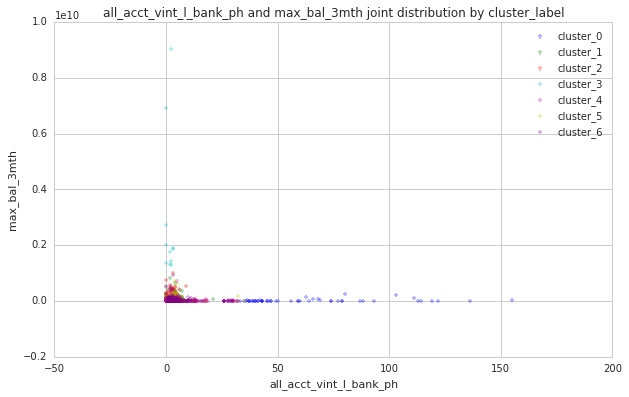

In [26]:
viz_joint('all_acct_vint_l_bank_ph', 'max_bal_3mth', 'cluster_label')

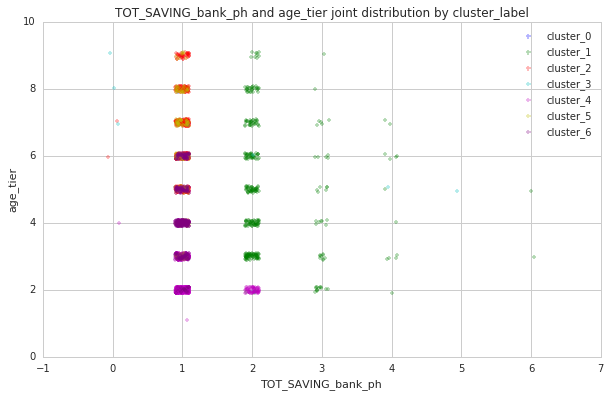

In [27]:
viz_joint('TOT_SAVING_bank_ph', 'age_tier', 'cluster_label')